# FFT Shear Image Rotationing
## Overview
In this project I will develop an algorithm for rotating images. A matrix that describes rotation by an angle $\theta$ counter-clockwise is given by $$R\left(\theta\right)=\left(\begin{array}{cc}\cos\left(\theta\right) & -\sin\left(\theta\right)\\\sin\left(\theta\right) & \cos\left(\theta\right)\end{array}\right)$$
This matrix can be decomposed as $$R\left(\theta\right)=\left(\begin{array}{cc}1 & -\tan\left(\frac{\theta}{2}\right)\\0 & 1\end{array}\right)\times\left(\begin{array}{cc}1 & 0\\\sin\left(\theta\right) & 1\end{array}\right)\times\left(\begin{array}{cc}1 & -\tan\left(\frac{\theta}{2}\right)\\0 & 1\end{array}\right)$$
Let $I(x,y)$ be an image (soon $x$ and $y$ will be given on a discrete grid). We would like to rotate $I$ by an angle $\theta$. This means that $$I_{\theta}(x,y) =I\left(R\left(\theta\right)\left(\begin{array}{c}x\\y\end{array}\right)\right)$$  
In words, the $(x,y)$ pixel of the original image is mapped to $R\left(\theta\right)\left(\begin{array}{c}x\\y\end{array}\right)$ pixel of the rotate image. Let’s thus explore how the pixels of the image $I$ are transformed. Since $R(\theta)$ is a product of three transformations, we can inspect the effect of each one separately. For the first transformation (the rightmost one):  
$$\left(\begin{array}{c}
x\\
y
\end{array}\right)\to\left(\begin{array}{cc}
1 & -\tan\left(\frac{\theta}{2}\right)\\
0 & 1
\end{array}\right)\left(\begin{array}{c}
x\\
y
\end{array}\right)=\left(\begin{array}{c}
x-y\tan\left(\frac{\theta}{2}\right)\\
y
\end{array}\right)$$
This means that the y row of the original image should be translated by $y\tan\left(\frac{\theta}{2}\right)$.
Such an operation on an image is called “Shear”. I am leaving to you to analyze the effect of these two matrices, but you can see my implementation on the code below.
The key idea is that applying each of the matrices requires only translating rows/columns the image, that is, only one-dimensional operations along the rows/columns of the image.  
This project is part of Workshop in Scientific Computing @ TAU by Yoel Shkolnisky & Nir Sochen.  
Reference: M. Unser, P. Thevenaz and L. Yaroslavsky, ”Convolution-based interpolation for fast, high-quality rotation of images,” in IEEE Transactions on Image Processing, vol. 4, no. 10, pp. 1371-1381, Oct. 1995.
## Code
*Imports*

In [33]:
import numpy as np
import pyfftw
import matplotlib.pyplot as plt
import skimage
from scipy import ndimage

*FFT functions*

In [16]:
def fft_1d_fftw(vec, direction):
    """
    Compute the one-dimensional FFT of a complex-valued input vector using FFTW.
    """
    vec_length = len(vec)
    input_vector = pyfftw.empty_aligned(vec_length, dtype='complex128')
    output_vector = pyfftw.empty_aligned(vec_length, dtype='complex128')
    fftw_direction = 'FFTW_BACKWARD'
    if direction == 'FFTW_BACKWARD':
        fftw_direction = 'FFTW_FORWARD'
    fft_object = pyfftw.FFTW(input_vector,
                             output_vector,
                             direction=fftw_direction)
    input_vector = np.array(vec, dtype='complex128')
    fft_a = fft_object(input_vector) \
        * (1/vec_length if direction == 'FFTW_BACKWARD' else vec_length)
    return fft_a

In [28]:
def fft_2d(arr, direction):
    """
    Computes the 2D FFT of a given array.
    """
    arr = np.array(arr, dtype=np.complex128)
    rows, columns = arr.shape
    for i in range(rows):
        arr[i, :] = fft_1d_fftw(arr[i, :], direction)
    for i in range(columns):
        arr[:, i] = fft_1d_fftw(arr[:, i], direction)
    return arr


*Centerd FFT functions*

In [29]:
def cfft_1d(vec, direction):
    """
    Computes the 1D FFT of a 0-centered given array.
    """
    vec = np.array(vec, dtype=np.complex128)
    n = len(vec)
    mid_n = n // 2
    vec = np.roll(vec, -mid_n)
    vec = fft_1d_fftw(vec, direction=direction)
    vec = np.roll(vec, mid_n)
    return vec

In [30]:
def shift_array(arr, sign=-1):
    """
    Shifts an input array along both axes by half of its size.
    """
    rows, columns = arr.shape
    mid_row = rows // 2
    mid_col = columns // 2
    arr = np.roll(arr, sign * mid_row, axis=0)
    arr = np.roll(arr, sign * mid_col, axis=1)
    return arr

def cfft_2d(arr, direction):
    """
    Computes the 2D FFT of a 0-centered given array.
    """
    arr = np.array(arr, dtype=np.complex128)
    arr = shift_array(arr, -1)
    arr = fft_2d(arr, direction=direction)
    arr = shift_array(arr, 1)
    return arr

*Shear operation function*

In [18]:
def shear_operation_fft(arr, delta):
    """
    Imply the shear operation on image using FFT algorithm
    """
    n= len(arr)
    arr_fft = cfft_1d(arr, 'FFTW_FORWARD')
    arr_fft *= np.exp(-2 * np.pi * 1j * np.arange(n) * delta / n)
    return np.abs(cfft_1d(arr_fft, 'FFTW_BACKWARD'))

*Imply Shear operations for rotation*

In [19]:
def shear_image_rotate(image, width, height, angle):
    if angle == 0:
        return image
    for y in range(width):
        image[y, :] = shear_operation_fft(image[y, :], -np.tan(angle / 2) * (y - width / 2))
    for x in range(height):
        image[:, x] = shear_operation_fft(image[:, x], np.sin(angle) * (x - height / 2))
    for y in range(width):
        image[y, :] = shear_operation_fft(image[y, :], -np.tan(angle / 2) * (y - width / 2))
    return image

*Padding and Cropping the image*

In [20]:
def padding(im):
    """
    Add padding for image before rotating
    """
    width, height = np.array(im.shape)
    width, height = int(width), int(height)
    dim = ((width, width), (height, height))
    return np.pad(im, dim)


def crop(image, im_rotated):
    """
    Croping the image to the original size
    """
    original_width, original_height = image.shape
    return im_rotated[
        original_width:-original_width,
        original_height:-original_height]

*Rotating function*

In [21]:
def rotate(input_image_matrix, angle):
    """
    Rotates the input image by the specified angle counter-clockwise using FFT and shear operations.
    """
    angle = angle % 360
    
    angle = np.deg2rad(angle)
    im_padded = padding(input_image_matrix.copy())
    y_length, x_length = im_padded.shape

    while angle > np.pi / 2:
        im_padded = shear_image_rotate(im_padded, y_length, x_length, np.pi / 2)
        angle -= np.pi / 2

    im_padded = shear_image_rotate(im_padded, y_length, x_length, angle)

    return crop(input_image_matrix,im_padded)

*MSE calculation function*

In [22]:
def mse(im_1, im_2):
    """
    Calc the MSE of the images
    """
    err = np.sum((im_1.astype("float") - im_2.astype("float")) ** 2)
    err /= float(im_1.shape[0] * im_1.shape[1])
    return err

## Functional tests
Progressing from $0$ degrees to $360$ degrees in increments of $15$ degrees each, visually inspecting that a full rotation is obtained.

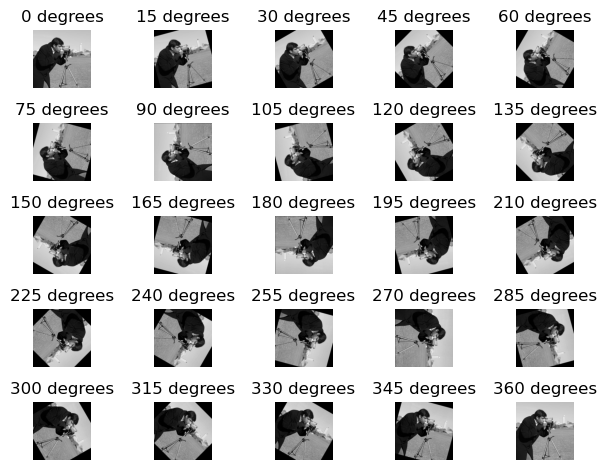

In [23]:
image = skimage.data.camera()
_, axs = plt.subplots(5, 5)
axs = np.array(axs).reshape(25)
for i, angle in enumerate(range(0, 375, 15)):
    rotated_image = rotate(image, angle)
    axs[i].imshow(rotated_image, cmap='gray')
    axs[i].set_title(f'{angle} degrees')
    axs[i].axis('off')
plt.tight_layout()

It can be observed that we indeed achieved a full rotation, returning to the original image state, indicating that the test was successful.  
Now, let's performing a full rotation of the image in parts and comparing SSIM and MSE to the original image, both visually and through their difference image.

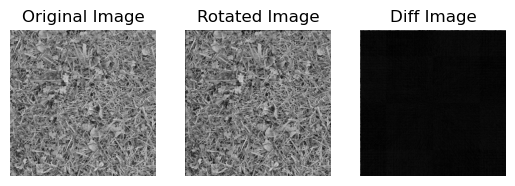

SSIM=0.9899349772137785, MSE=106.90798950195312


In [24]:
image = skimage.data.grass()
fft_rotated_180 = rotate(image, 180)
fft_rotated_180_180 = rotate(fft_rotated_180, 180)
diff = image - fft_rotated_180_180

fig, axes = plt.subplots(1, 3)

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(fft_rotated_180_180, cmap='gray')
axes[1].set_title('Rotated Image')
axes[1].axis('off')

axes[2].imshow(diff, cmap='gray')
axes[2].set_title('Diff Image')
axes[2].axis('off')
result_ssim_fft = skimage.metrics.structural_similarity(
        image,
        fft_rotated_180_180)
result_mse_fft = mse(image, fft_rotated_180_180)
plt.show()
print(f'SSIM={result_ssim_fft}, MSE={result_mse_fft}')

It can be seen that we obtained relatively good SSIM and MSE values, indicating that the images are quite similar. This is also evident in the difference image, which shows very subtle noise. This is because the image contains many edges, which FFT is known to handle well.  
Now, let's manually rotate the image using graphic tools (such as Photoshop), perform the rotation in code at the same angle, and compare them using SSIM and MSE, as well as visually through their difference image.

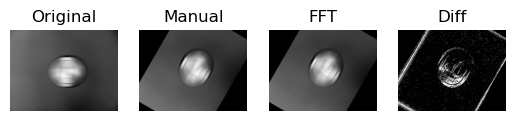

SSIM=0.9809576418358483, MSE=9.582975


In [27]:
image_clock = plt.imread('images/clock.jpg')[:, :, 2]
fft_rotated = rotate(image_clock, 60)
manually_rotated = plt.imread('images/clock_rotated.jpg')[:, :, 2]
diff = manually_rotated - fft_rotated
fig, axes = plt.subplots(1, 4)

axes[0].imshow(image_clock, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(manually_rotated, cmap='gray')
axes[1].set_title('Manual')
axes[1].axis('off')

axes[2].imshow(fft_rotated, cmap='gray')
axes[2].set_title('FFT')
axes[2].axis('off')

axes[3].imshow(diff, cmap='gray')
axes[3].set_title('Diff')
axes[3].axis('off')

result_ssim_python = skimage.metrics.structural_similarity(
    fft_rotated,
    manually_rotated)
result_mse_python = mse(fft_rotated, manually_rotated)
plt.show()
print(f'SSIM={result_ssim_python}, MSE={result_mse_python}')

In this image, we obtained even better SSIM and MSE values compared to the first image. However, a closer analysis of the difference image allows us to better examine the drawbacks of the algorithm. Beyond the noise that was visible in the previous image, here we can see that the edges of the image are not in the same position and are slightly blurred, indicating that the rotation angle is not accurate.  
Therefore, it is clear that the algorithm performs the rotations as required but loses some information along the way and executes the rotation inaccurately.

## Accurency Tests
First, we'll apply a segmented full rotation to the same image using each of the functions. Then, we'll compare the SSIM and MSE values and their difference image. Additionally, we'll create a difference image of their two-dimensional FFT centered transformations to understand what was lost along the way.  
*FFT output*

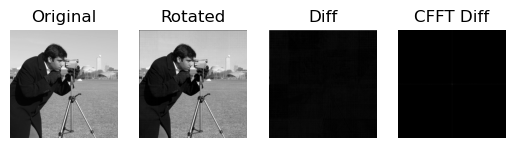

SSIM=0.9252019739605317, MSE=155.57731246948242


In [31]:
image = skimage.data.camera()
fft_rotated = rotate(image, 90)
fft_rotated = rotate(fft_rotated, 90)
fft_rotated = rotate(fft_rotated, 180)
diff = image - fft_rotated
cfft_image = cfft_2d(image, direction='FFTW_FORWARD')
cfft_fft_rotated = cfft_2d(fft_rotated, direction='FFTW_FORWARD')
diff_cfft = cfft_image - cfft_fft_rotated

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.imshow(image, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(fft_rotated, cmap='gray')
ax2.set_title('Rotated')
ax2.axis('off')

ax3.imshow(diff, cmap='gray')
ax3.set_title('Diff')
ax3.axis('off')

ax4.imshow(np.abs(diff_cfft), cmap='gray')
ax4.set_title('CFFT Diff')
ax4.axis('off')

result_ssim = skimage.metrics.structural_similarity(image, fft_rotated)
result_mse = mse(image, fft_rotated)
plt.show()
print(f'SSIM={result_ssim}, MSE={result_mse}')

*Python library output*

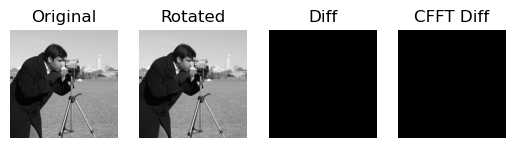

SSIM=1.0, MSE=0.0


In [35]:
python_rotated = ndimage.rotate(image, 90)
python_rotated = ndimage.rotate(python_rotated, 90)
python_rotated = ndimage.rotate(python_rotated, 180)

diff = image - python_rotated
cfft_python_rotated = cfft_2d(python_rotated, direction='FFTW_FORWARD')
diff_cfft = cfft_image - cfft_python_rotated

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.imshow(image, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(python_rotated, cmap='gray')
ax2.set_title('Rotated')
ax2.axis('off')

ax3.imshow(diff, cmap='gray')
ax3.set_title('Diff')
ax3.axis('off')

ax4.imshow(np.abs(diff_cfft), cmap='gray')
ax4.set_title('CFFT Diff')
ax4.axis('off')

result_ssim = skimage.metrics.structural_similarity(image, python_rotated)
result_mse = mse(image, python_rotated)
plt.show()
print(f'SSIM={result_ssim}, MSE={result_mse}')

Notice that for the function I wrote, we get a rotated image but not at the exact angle. Also, the quality of the image is not the same as the original image. This is evident in the noise we received and additionally, in the centered FFT we obtained, there's a certain point in the middle and a faint white cross, indicating information loss in the algorithm. In contrast, using the Python library function, we got the best possible values. The images are completely identical with no difference between them. Furthermore, it's worth noting that while my function provided good SSIM and MSE values, the library function gave the best possible values. Therefore, based on this test, the library function is inherently more accurate.  

To illustrate the significance of images with intricate details and boundaries when using the algorithm I developed, I took a white square measuring 500x500 pixels. I rotated it by 45 degrees using Photoshop, then rotated it again using each of the functions. I conducted a comparison between the images. Once between the manually rotated image and the one rotated using my algorithm, and a second time between the manually rotated image and the one rotated using the library function. Below are the results:

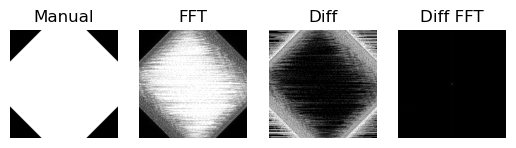

SSIM=0.23636675464698964, MSE=10948.874744


In [37]:
image = plt.imread('images/white_rect.jpg')[:, :, 2]
rotated_image = plt.imread('images/white_rect_rotated_45.jpg')[:, :, 2]
cfft_rotated_image = cfft_2d(rotated_image, direction='FFTW_FORWARD')

fft_rotated_image = rotate(image, 45)
cfft_fft_rotated_image = cfft_2d(
    fft_rotated_image,
    direction='FFTW_FORWARD')

diff_ftt_rotate = rotated_image - fft_rotated_image
fft_diff_ftt_rotate = cfft_rotated_image - cfft_fft_rotated_image
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.imshow(rotated_image, cmap='gray')
ax1.set_title('Manual')
ax1.axis('off')

ax2.imshow(fft_rotated_image, cmap='gray')
ax2.set_title('FFT')
ax2.axis('off')

ax3.imshow(diff_ftt_rotate, cmap='gray')
ax3.set_title('Diff')
ax3.axis('off')

ax4.imshow(np.abs(fft_diff_ftt_rotate), cmap='gray')
ax4.set_title('Diff FFT')
ax4.axis('off')
plt.show()

result_ssim_fft = skimage.metrics.structural_similarity(
    fft_rotated_image,
    rotated_image)

print(f'SSIM={result_ssim_fft}, MSE={mse(fft_rotated_image, rotated_image)}')


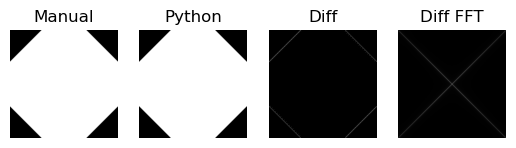

SSIM=0.9864022531058143, MSE=126.550484


In [39]:
python_rotated_image = ndimage.rotate(image, 45,reshape=False)
cfft_python_rotated_image = cfft_2d(
    python_rotated_image,
    direction='FFTW_FORWARD')
diff_python_rotate = rotated_image - python_rotated_image
fft_diff_python_rotate = cfft_rotated_image - cfft_python_rotated_image


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(rotated_image, cmap='gray')
ax1.set_title('Manual')
ax1.axis('off')

ax2.imshow(python_rotated_image, cmap='gray')
ax2.set_title('Python')
ax2.axis('off')

ax3.imshow(diff_python_rotate, cmap='gray')
ax3.set_title('Diff')
ax3.axis('off')

ax4.imshow(np.abs(fft_diff_python_rotate), cmap='gray')
ax4.set_title('Diff FFT')
ax4.axis('off')

plt.show()

result_ssim_python = skimage.metrics.structural_similarity(
    python_rotated_image,
    rotated_image)

print(f'SSIM={result_ssim_python}, MSE={mse(python_rotated_image, rotated_image)}')

As evident, for my algorithm, we do get a rotated image, but in reality, the image is distorted and is no longer a white square; rather, it contains significant noise and is not accurately rotated at a 45-degree angle (manifested in the misalignment of the boundaries). It can be observed that the main loss of information occurs at the algorithm's midpoint, as indicated by the FFT subtraction. It can also be understood that this happens due to the Shear operation, which at some point "shifts" some data to the center, thereby losing information. For the library function, it seems that the angle is precisely the one requested, and it does not lose information. There are differences in the shape outlines, likely due to the graphic tool I used, rather than the function itself. Additionally, it is noteworthy that the SSIM and MSE values we obtained for our algorithm are very low, suggesting that it is not the same image at all. Conversely, for the library function, we obtained excellent values, indicating that the images are very similar. Therefore, based on this test, the library function is inherently more accurate.

# Conclusion
Indeed, the algorithm we developed does work, and for images with many details, it provides a good rotation. However, when it comes to more abstract images or those lacking many small details, we lose information and may obtain a different and incorrect image. Additionally, the rotation angle is not precisely the one we defined, but it is very, very close. On the other hand, the library function provides us with an excellent and fast tool for rotating images with very high accuracy, more so than our function.